# Coding project - classification of text

The goal of this project is to evaluate your capacity to design a deep learning pipeline for **text** analysis on a real case study, from data processing to interpretation of the model's result. The project accounts for 60% of the course's grade, and will be evaluated as follows:

Criterion | Weight |Details
-------------------|------------------|----------
Quality of the oral  | 30% | Clarity, discussion, ideas for improvement
Coding quality | 30% | Relevant methods, advanced techniques, quality of implementation, reproducibility
Interpretation | 30% | Relevance and quality of interpretation, quality of visual representations
Performance | 10% | Final performance on the classification task of interest

# Predicting mental health status from textual statements

## Motivations

Mental disorders encompass a diverse set of pathologies which range from episodic anxiety and depression, to eating disorders, bipolarity or psychotic. Mental health is one of the most significant public health issues, as up to 29% of the global population will experiment a mental disorder throughout their lives ; it is also the primary expenditure item of the Social Security in France. One of the major issues is the deployment of efficient prevention tools, in order to identify people at risk and to refer them to a medical doctor. Some solutions have started to emerge, in particular in the form of smartphone apps which sometimes include chatbot tools, as illustrated on the images below. In this context, an interesting question from a machine learning perspective, is the identification of potential mental disorders from textual statements.

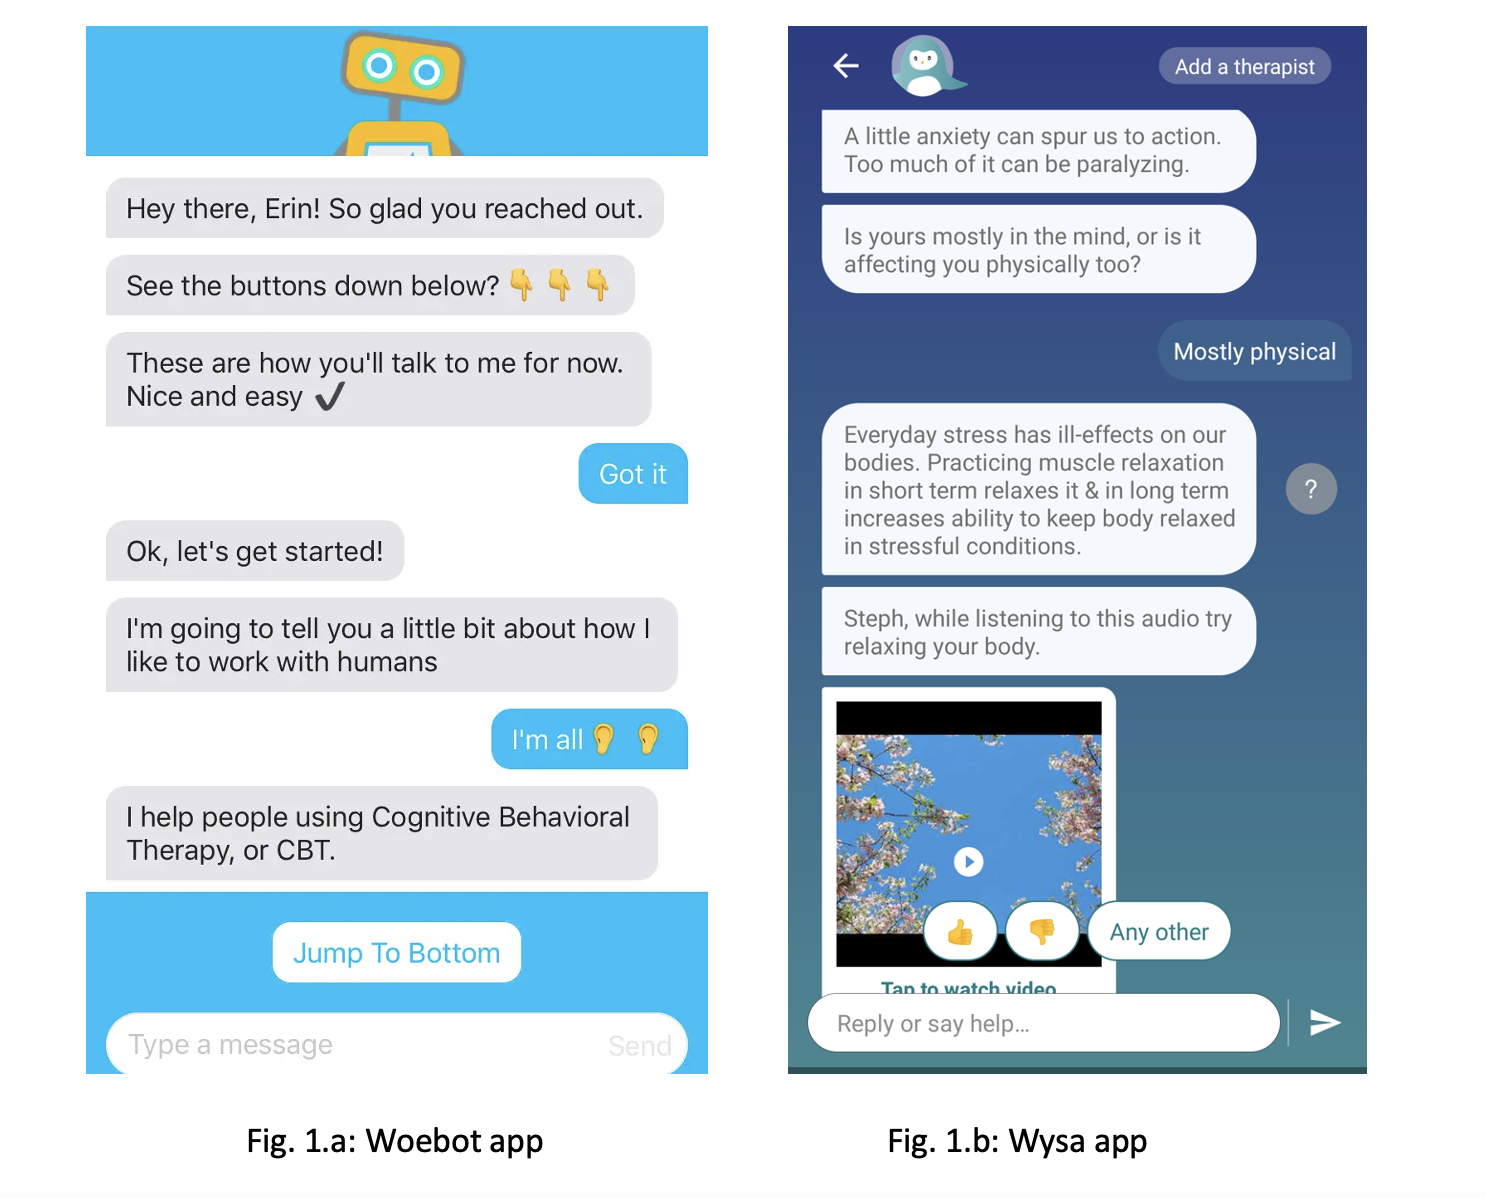

## Set up

Don't forget to change the device to GPU T4

In [1]:
import torch

### TODO: set the device to "cuda" if a GPU is available, "CPU" otherwise

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Download the data set using the following code, and check the variable `path` to see where the downloaded folder is located.

In [30]:
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
import kagglehub
from glob import glob
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, Dataset,TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import DistilBertTokenizer,AutoTokenizer,AutoModel
from transformers import DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

In [3]:
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sentiment-analysis-for-mental-health' dataset.
Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [4]:
# Load the CSV data set into a data frame
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)

In [5]:
# Show random 5 rows of the data set
df.sample(5)

,statement,status
47335,I get sad in spring I hate this time of year. ...,Depression
17996,"Hello, I am sure you have heard those stories ...",Depression
20133,I really do not understand why I exist. I have...,Suicidal
22133,that is what you get for opening to someone I ...,Depression
49705,NaN,Bipolar


## Work by yourself

The goal of this project is for you to develop autonomously a whole deep learning pipeline to classify the patch images into IDC negative (0) and IDC positive (1). To complete the assignment, you are required to address the following points:

***Set-up your pipeline:***
- Start by processing the textual statements. You can use some of the code of TP4, but be careful as the statements may containt different types of anomalies and particularities.
- Explore the data with summaries and visualizations to understand how classes are balanced, etc.
- Split the data into training, test and validation sets.
- Train a first model to predict mental status and evaluate it on the validation data.

***Improve the performance of your model:***
- Experiment with different network architectures and with pre-trained models.
- Experiment how class imbalance can be dealt with, for instance using resampling, class weighting, or any other method of your choice.
- Tune the hyperparameters of the different models and compare their performance using different evaluation metrics.

***Interpret your results:***
- Implement an interpretation analysis using one or several tools of your choice. For instance [LIME](https://pypi.org/project/lime/), [SHAP](https://pypi.org/project/shap/), or any other method of your choice.
- Provide visual representations of the interpretation analysis, and comment the results.
- Provide a general conclusion to your project which summarizes your results and findings, as well as possible ideas of improvement.

## ETUDE DU DATASET

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
df["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

La colonne "statue" identifie l'état mental de la personne . il y en a 7 différents en tout  .

In [8]:

df['status'].value_counts()/len(df)*100

,count
status,
Normal,30.825934
Depression,29.040590
Suicidal,20.083706
Anxiety,7.329902
Bipolar,5.423901
Stress,5.031767
Personality disorder,2.264201


On affiche le pourcentage des états mental au sein du dataset , on a une grande proportion de personnes dans un état "normal " de 30 % ,suivit de l'état "dépression" et "sucidaire" autour des 20 % . L'état avec le plus faible poucentage d'apparition est l'état de " désordre de la personalité "

In [9]:
df['statement'].value_counts()

,count
statement,
what do you mean?,22
why not?,16
#NAME?,13
ni-ki best boy,11
Survey on Situational Stress and Music (18 and up) I am a research student doing research on Situational Stress. Please help me and complete my survey for this project. Thank you!\n[https://forms.gle/JDgUZQmLXRNCuFXD7](https://forms.gle/JDgUZQmLXRNCuFXD7),10
...,...
If you had a mental health emergency for extremely suicidal thoughts and had to be admitted to a psychiatric ward for inpatient treatment could you be fired? My work has FMLA but it apparently needs to be filled out months in advance for you to be able to use it and have it approved. I have a previous diagnosis for depression and anxiety but stopped seeing a therapist for ahwile. I recently started seeing a new one but I have only had a couple appointments with them. I live in California in the US. Being admitted to a psychiatric ward for suicidal thoughts get you fired?,1
Can you be fired for being admitted to a psychiatric ward for suicide risk? If you had to stay inpatient and did not have FMLA filled out beforehand could you lose your job? Mental health emergency and your job?,1
I feel like this might be the wrong place to ask but I cannot find the answer anywhere online. Is zopiclone and alcohol a lethal combination?,1


on observe que certaines phrases reviennent assez souvent comme "what do u mean" qui apparaissent 20 fois dans le dataset , mais la plupart n apparaissent qu'une fois . C est assez rare d'écrire 2 phrases identiques . On observe aussi que il y a parfois des mots en majuscule comme "TALK TO SOMEONE" ce qui peut freiner l 'apprentissage de notre algorithme , on va donc les mettre en miniscules .

In [10]:
df['statement']=df['statement'].str.lower()

In [11]:
df.head(10)

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"all wrong, back off dear, forward doubt. stay ...",Anxiety
3,i've shifted my focus to something else but i'...,Anxiety
4,"i'm restless and restless, it's been a month n...",Anxiety
5,"every break, you must be nervous, like somethi...",Anxiety
6,"i feel scared, anxious, what can i do? and may...",Anxiety
7,have you ever felt nervous but didn't know why?,Anxiety
8,"i haven't slept well for 2 days, it's like i'm...",Anxiety
9,"i'm really worried, i want to cry.",Anxiety


In [12]:
df.isnull().value_counts()

,,count
statement,status,
False,False,52681
True,False,362


Il y a 362 données qui ne contiennent aucun mot , ce nombre est assez négligeable comparé au nombre de données totale qui est de 53043 . Je choisit donc de simplement retirer les données qui ne contiennet aucun mot .

In [13]:
df=df.dropna()

On va ensuite nettoyer les phrases

In [14]:
def clean_text(text):

    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"@\w+|\#", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"rt ", "", text)
    text = re.sub(r"\s+", " ", text)
    return text

df["statement"] = df["statement"].apply(clean_text)

## Codage des features

On commence par encoder les états mentaux des individus ,en partant de 0 l état normal , jusqu'à 6 , l état le plus préoccupant 'suicidaire'. On classifie les état du plus normal au plus dangereux .

In [15]:
df['status'].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [16]:
dico={'Normal':0,'Stress':1,'Anxiety':2,'Depression':3,'Personality disorder':4,'Bipolar':5,'Suicidal':6}
df['status_encoded']=df['status'].map(dico)

## Modèle Pré entrainé

Avant toute chose , on sépare les données pour avoir un jeu de données pour l entrainement , un pour la validation , et un autre pour le test . Le jeu de test ne sera modifié durant toutes les étapes , on ne l'utiliser qu'à la fin pour évaluer notre modèle

In [28]:
X_train,X_test,y_train,y_test=train_test_split(df['statement'],df['status_encoded'],test_size=0.4)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5)

print(f"La taille du dataset d'entrainement est de  :{len(X_train)} qui représente {round(len(X_train)/len(df['statement'])*100)}% du dataset")
print(f"La taille du dataset de validation est de  :{len(X_val)} qui représente {round(len(X_val)/len(df['statement'])*100)}% du dataset")
print(f"La taille du dataset de test :{len(X_test)} qui représente {round(len(X_test)/len(df['statement'])*100)}% du dataset")

La taille du dataset d'entrainement est de  :31608 qui représente 60% du dataset
La taille du dataset de validation est de  :10536 qui représente 20% du dataset
La taille du dataset de test :10537 qui représente 20% du dataset


on définit le tokenizer qui va transformer les phrases en tokens c'est à dire que chaque mot sera associer a un vecteur à valeurs réelles . On fait cela car un modèle de machine learning ne peut interpréter que des valeurs numériques . On introduira aussi un modèle transformer appelée bert qui servira de modèle qu on fine tunera , c est a dire qu il sera pré entrainé donc la plupart des paramètres seront fixé mais on modifiera la tête pour l entrainer sur nos données  

In [31]:
tokenizer=AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
bert_model=AutoModel.from_pretrained("google-bert/bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
y_train.value_counts()/len(y_train)

,count
status_encoded,
0,0.311915
3,0.292964
6,0.202164
2,0.070995
5,0.053373
1,0.048722
4,0.019868


On observe que le dataset d'entrainement n'est pas équilibré , c'est à dire que les classes ne sont pas répartit équitablement , on a par exemple 31% de messages de la classe normal et 1% de la classe "personallity disorder " . Si on entraine le modèle en l'état , il n arrivera pas a prédire les classes les moins représentés . Pour palier a cela , dans la loss fonction on va définir des poids pour les classes en fonction de leur proportion dans le dataset , cela permettra de pénaliser beaucoup plus les erreurs sur les classes minoritaire et donc d augmenter leur taux de prédictions

In [33]:
from sklearn.utils import class_weight

classes = np.unique(df['status_encoded'])

class_weights = list(class_weight.compute_class_weight('balanced',classes=classes,y=df['status_encoded']))

class_weights_tensor = torch.tensor(class_weights,dtype=torch.float32)

class_weights_tensor = class_weights_tensor.to(device)

In [34]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

On définit la fonction pour créer les dataset en torch

In [35]:
class dataset(Dataset):
    def __init__(self, X, Y, max_len=125):
        self.encodings = tokenizer(
            list(X),
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_tensors=None   # ← IMPORTANT
        )
        self.labels = torch.tensor(Y.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
        }, self.labels[idx]


on définit les datasets d'entrainement de validation et de test

In [36]:
training_data=dataset(X_train,y_train)
validation_data=dataset(X_val,y_val)
test_data=dataset(X_test,y_test)

on définit les hyperparamètres du modèle , la taille du batch , les epochs et le learning rate

In [37]:
batch_size=64
epochs=5
lr=10**(-5)

In [38]:
train_dataloader=DataLoader(training_data,batch_size=batch_size,shuffle=True)
val_dataloader=DataLoader(validation_data,batch_size=batch_size,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size,shuffle=True)

On créer un modèle qui sera en grande partie le modele bert puis on y ajoute a la tête pour que le modèle s entraine dessus et arrive a prédire les classes

In [39]:
class MyModel(nn.Module):
    def __init__(self,bert):
        super(MyModel,self).__init__()
        self.bert=bert
        self.dropout=nn.Dropout(0.3)
        self.linear1=nn.Linear(768,384)
        self.relu = nn.ReLU()
        self.linear2=nn.Linear(384,7)

    def forward(self,input_ids,attention_mask):
        output=self.bert(input_ids,attention_mask,return_dict=False)[0][:,0]
        output=self.dropout(output)
        output=self.linear1(output)
        output = self.relu(output)
        output=self.linear2(output)
        return output

On gèle les paramêtres du modele bert

In [41]:

for param in bert_model.parameters():
    param.requires_grad = True


model=MyModel(bert_model).to(device)

On définit la méthode d optimisation qui sera adam

In [42]:
optimizer=optim.Adam(model.parameters(),lr=lr)

On définit la boucle d'entrainement et de validation on calculera a la fin la précision de du set d'entrainement et de validation , c est à dire le pourcentage de bonnes prédiction à chaque époques . On calculera aussi plusieurs autres métrique . Puisqu on a plusieurs classes ,on utilisera la méthode one vs all , c 'est à dire que l on compte comme mauvaise prédiction d une classe A , toutes les prédicition qui on prédit la classe A alors qu ils ne sont pas dans cette classe , le recall qui mesure le taux de vrai positive parmi toute les valeur prédites positives . le F1 score calcule une moyenne harmonique entre la précision et le recall , le support compte simplement le nombre de réel échantillons de chaque classe .

In [43]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
from tqdm import tqdm
for epoch in range(5):

    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_dataloader, desc="Training", leave=False):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(correct / total)

    # VALIDATION
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_dataloader, desc="Validation", leave=False):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            outputs = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"]
            )

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss.append(running_loss / len(val_dataloader))
    val_acc.append(correct / total)

    print(f"Epoch {epoch+1} | "
          f"Train acc: {train_acc[-1]:.3f} | "
          f"Val acc: {val_acc[-1]:.3f}")
    print(
    classification_report(
        all_labels,
        all_preds,
        digits=3
    )
)




Epoch 1 | Train acc: 0.625 | Val acc: 0.719
              precision    recall  f1-score   support

           0      0.926     0.892     0.909      3255
           1      0.416     0.697     0.521       534
           2      0.665     0.872     0.754       779
           3      0.757     0.531     0.624      3079
           4      0.317     0.844     0.461       224
           5      0.767     0.748     0.757       547
           6      0.632     0.654     0.643      2118

    accuracy                          0.719     10536
   macro avg      0.640     0.748     0.667     10536
weighted avg      0.751     0.719     0.724     10536



Epoch 2 | Train acc: 0.754 | Val acc: 0.751
              precision    recall  f1-score   support

           0      0.943     0.908     0.925      3255
           1      0.486     0.794     0.603       534
           2      0.800     0.854     0.826       779
           3      0.870     0.464     0.606      3079
           4      0.563     0.795     0.659       224
           5      0.778     0.806     0.792       547
           6      0.572     0.857     0.686      2118

    accuracy                          0.751     10536
   macro avg      0.716     0.783     0.728     10536
weighted avg      0.797     0.751     0.747     10536



Epoch 3 | Train acc: 0.799 | Val acc: 0.787
              precision    recall  f1-score   support

           0      0.949     0.918     0.933      3255
           1      0.583     0.783     0.668       534
           2      0.794     0.890     0.839       779
           3      0.805     0.648     0.718      3079
           4      0.488     0.808     0.608       224
           5      0.710     0.870     0.782       547
           6      0.674     0.725     0.698      2118

    accuracy                          0.787     10536
   macro avg      0.715     0.806     0.750     10536
weighted avg      0.800     0.787     0.788     10536



Epoch 4 | Train acc: 0.825 | Val acc: 0.801
              precision    recall  f1-score   support

           0      0.947     0.933     0.940      3255
           1      0.581     0.809     0.676       534
           2      0.844     0.870     0.857       779
           3      0.831     0.646     0.727      3079
           4      0.665     0.790     0.722       224
           5      0.761     0.874     0.814       547
           6      0.659     0.777     0.713      2118

    accuracy                          0.801     10536
   macro avg      0.756     0.814     0.778     10536
weighted avg      0.813     0.801     0.801     10536



Epoch 5 | Train acc: 0.846 | Val acc: 0.798
              precision    recall  f1-score   support

           0      0.971     0.902     0.935      3255
           1      0.584     0.811     0.679       534
           2      0.839     0.869     0.854       779
           3      0.809     0.673     0.735      3079
           4      0.735     0.754     0.744       224
           5      0.694     0.899     0.783       547
           6      0.661     0.769     0.711      2118

    accuracy                          0.798     10536
   macro avg      0.756     0.811     0.777     10536
weighted avg      0.813     0.798     0.801     10536



Text(0.5, 1.0, 'test accurency')

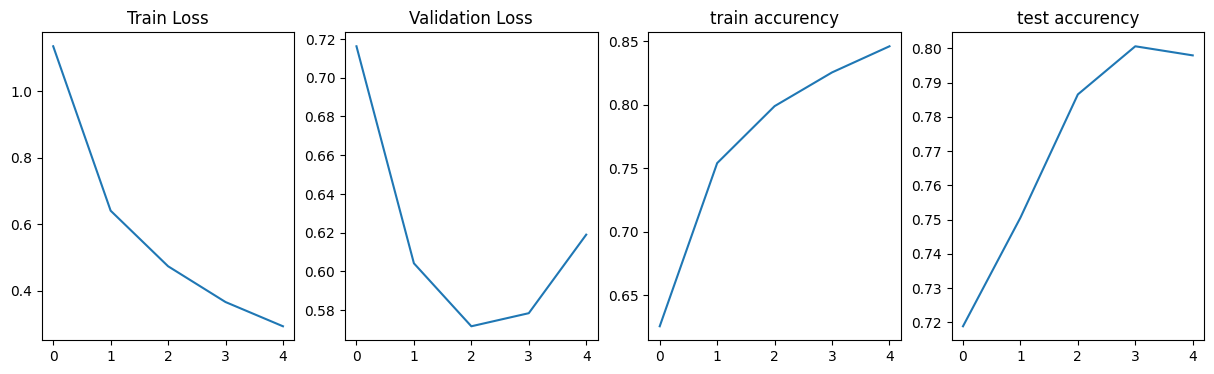

In [87]:
fig, ax = plt.subplots(ncols=4, figsize=(15,4))

ax[0].plot(train_loss)
ax[0].set_title("Train Loss")

ax[1].plot(val_loss)
ax[1].set_title("Validation Loss")

ax[2].plot(train_acc)
ax[2].set_title("train accurency")

ax[3].plot(val_acc)
ax[3].set_title("test accurency")

In [44]:
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import torch

# ---------- TEST ----------
model.eval()

test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Testing"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Moyennes
test_loss /= len(test_dataloader)
test_acc = correct / total

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

print(
    classification_report(
        all_labels,
        all_preds,
        digits=3
    )
)


Testing: 100%|██████████| 165/165 [01:10<00:00,  2.35it/s]

Test loss: 0.6050
Test accuracy: 0.7922
              precision    recall  f1-score   support

           0      0.966     0.893     0.928      3229
           1      0.535     0.815     0.646       513
           2      0.857     0.861     0.859       818
           3      0.806     0.665     0.729      3065
           4      0.702     0.787     0.742       225
           5      0.694     0.862     0.769       543
           6      0.665     0.774     0.715      2144

    accuracy                          0.792     10537
   macro avg      0.747     0.808     0.770     10537
weighted avg      0.809     0.792     0.795     10537



In [45]:
import os

os.makedirs("model", exist_ok=True)


torch.save(model, "model/model.pt")

tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [48]:
import gradio as gr

In [72]:
keys_array = np.array(list(dico.keys()))
MODEL_PATH = "model"  # chemin vers votre modèle sauvegardé
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = torch.load(f"{MODEL_PATH}/model.pt", map_location='cpu', weights_only=False)
model.eval()


labels=keys_array

def predict(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )
        pred = torch.argmax(outputs, dim=1).item()
    return labels[pred]


iface = gr.Interface(
    fn=predict,                   # fonction de prédiction
    inputs=gr.Textbox(lines=5),   # entrée texte
    outputs="text",
    title="Classification de message sur l'état de santé mentale",
    description=f'Entrez un texte en anglais pour obtenir la prédiction de classe (Normal,stress,anxiety,depression,personnality disorder,bipolar,suicidal) \n comme par exemple : it feels uneasy '
)


iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c90d976db6fbc22c1e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
